In [26]:
import os
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---------------------------------------------------------------------------------------------------

#### loading data

In [3]:
# Paths
data_dir = r"C:\Users\LOQ\Desktop\cifar10"
train_dir = os.path.join(data_dir, 'train')
test_dir  = os.path.join(data_dir, 'test')

---------------------------------------------------------------------------------------------------

#### Preprocessing & Augmentation

In [4]:
# CIFAR-10 normalization constants
data_mean = [0.4914, 0.4822, 0.4465]
data_std  = [0.2023, 0.1994, 0.2010]

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)
])

In [6]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std)
])

In [7]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transforms)

In [8]:
len(train_dataset)

50000

In [9]:
len(test_dataset)

10000

In [10]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

---------------------------------------------------------------------------------------------------

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
from torchvision.utils import make_grid

def show_images(dataloader):
    images, labels = next(iter(dataloader))
    img_grid = make_grid(images[:16], nrow=4, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0).cpu())
    plt.title('Sample Images from CIFAR-10')
    plt.axis('off')
    plt.show()
    print("Labels:", [class_names[label] for label in labels[:16]])

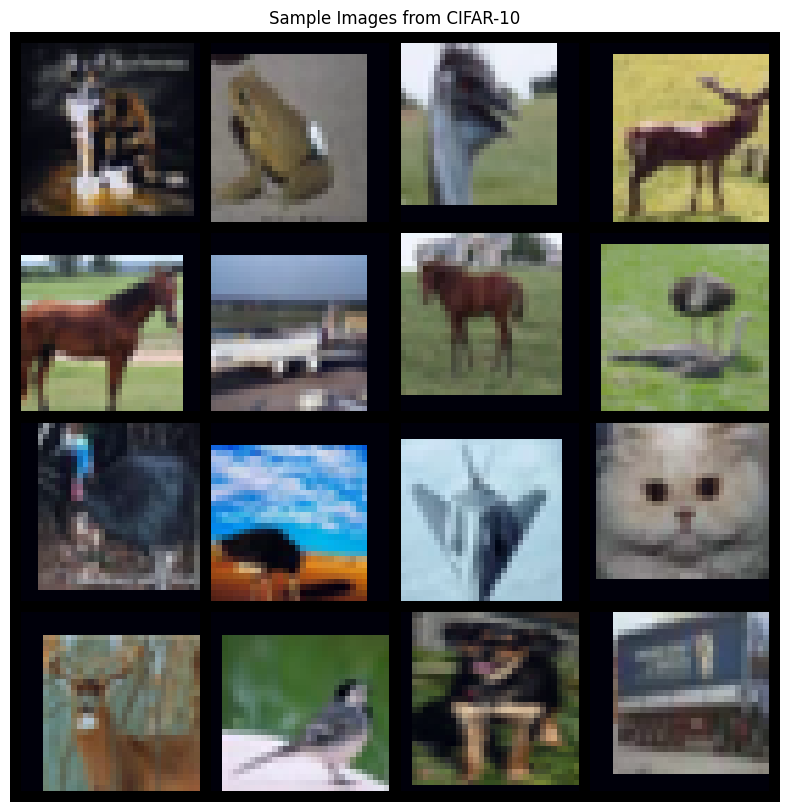

Labels: ['cat', 'frog', 'bird', 'deer', 'horse', 'airplane', 'horse', 'bird', 'bird', 'bird', 'airplane', 'cat', 'deer', 'bird', 'dog', 'truck']


In [13]:
# checking samples
show_images(train_loader)

---------------------------------------------------------------------------------------------------

#### Vision Transformer (ViT) Implementation

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [15]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, D)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [16]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

In [17]:
class Block(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_drop, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dim, drop)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [18]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, n_classes=10,
                 embed_dim=192, depth=12, n_heads=12, mlp_ratio=4., qkv_bias=True,
                 drop_rate=0.1, attn_drop_rate=0.):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)
        self.blocks = nn.ModuleList([
            Block(embed_dim, n_heads, mlp_ratio, qkv_bias, drop_rate, attn_drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None: nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        for blk in self.blocks: x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])


In [19]:
# Instantiate ViT
vit = VisionTransformer().to(device)

In [20]:
vit

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=192, out_features=10, bias=Tr

---------------------------------------------------------------------------------------------------

#### Training Utilities

In [21]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

In [22]:
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        loss = criterion(out, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return running_loss/len(loader.dataset), acc, prec, rec, f1, cm

---------------------------------------------------------------------------------------------------

#### Training ViT for classification

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR


In [23]:
# hyperparams
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=3e-4, weight_decay=0.02)

In [ ]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)

In [ ]:
early_stopping = {"patience":10, "best_score":0.0, "epochs_no_improve":0}

#### Training with 20 epochs

In [46]:
n_epochs = 20
best_acc = 0.0
best_model_wts = copy.deepcopy(vit.state_dict())
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

In [47]:
for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    
    # Train and get loss, accuracy
    train_loss, train_acc = train_one_epoch(vit, train_loader, criterion, optimizer, device)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    
    # eval on validation set
    val_loss, val_acc, val_prec, val_rec, val_f1, cm = evaluate(vit, test_loader, criterion, device)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)
    
    # Scheduler step 
    scheduler.step(val_acc)
    
    # Early stopping check
    if val_acc > early_stopping["best_score"]:
        early_stopping["best_score"] = val_acc
        early_stopping["epochs_no_improve"] = 0
        best_model_wts = copy.deepcopy(vit.state_dict())
    else:
        early_stopping["epochs_no_improve"] += 1
        if early_stopping["epochs_no_improve"] >= early_stopping["patience"]:
            print(f"Early stopping @ epoch {epoch}")
            break
    
    # epoch results
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | "
          f"Time: {time.time() - t0:.1f}s")

Epoch 01 | Train Loss: 1.0567 | Train Acc: 0.6230 | Val Loss: 0.9671 | Val Acc: 0.6544 | Val F1: 0.6479 | Time: 107.9s
Epoch 02 | Train Loss: 1.0088 | Train Acc: 0.6402 | Val Loss: 0.9754 | Val Acc: 0.6564 | Val F1: 0.6512 | Time: 108.6s
Epoch 03 | Train Loss: 0.9637 | Train Acc: 0.6547 | Val Loss: 0.9146 | Val Acc: 0.6744 | Val F1: 0.6707 | Time: 145.2s
Epoch 04 | Train Loss: 0.9298 | Train Acc: 0.6702 | Val Loss: 0.8833 | Val Acc: 0.6859 | Val F1: 0.6804 | Time: 161.7s
Epoch 05 | Train Loss: 0.8875 | Train Acc: 0.6841 | Val Loss: 0.8611 | Val Acc: 0.6956 | Val F1: 0.6906 | Time: 161.5s
Epoch 06 | Train Loss: 0.8547 | Train Acc: 0.6972 | Val Loss: 0.8459 | Val Acc: 0.7007 | Val F1: 0.6998 | Time: 164.6s
Epoch 07 | Train Loss: 0.8260 | Train Acc: 0.7052 | Val Loss: 0.8299 | Val Acc: 0.7109 | Val F1: 0.7100 | Time: 166.3s
Epoch 08 | Train Loss: 0.7995 | Train Acc: 0.7171 | Val Loss: 0.7752 | Val Acc: 0.7250 | Val F1: 0.7195 | Time: 167.2s
Epoch 09 | Train Loss: 0.7714 | Train Acc: 0.726

In [48]:
# Save ViT model
vit.load_state_dict(best_model_wts)

<All keys matched successfully>

---------------------------------------------------------------------------------------------------

#### Training with 50 epochs

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=3e-4, weight_decay=0.02)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
early_stopping = {"patience":10, "best_score":0.0, "epochs_no_improve":0}

In [30]:
# training pt.2 

n_epochs = 60
best_acc = 0.0
best_model_wts = copy.deepcopy(vit.state_dict())
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

In [31]:
for epoch in range(1, n_epochs+1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(vit, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, cm = evaluate(vit, test_loader, device)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    # early stopping
    if val_acc > early_stopping["best_score"]:
        early_stopping["best_score"] = val_acc
        early_stopping["epochs_no_improve"] = 0
        best_model_wts = copy.deepcopy(vit.state_dict())
    else:
        early_stopping["epochs_no_improve"] += 1
        if early_stopping["epochs_no_improve"] >= early_stopping["patience"]:
            print(f"Early stopping @ epoch {epoch}")
            break

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | "
          f"Time: {time.time()-t0:.1f}s")

Epoch 01 | Train Loss: 1.5014 | Train Acc: 0.4518 | Val Loss: 1.4015 | Val Acc: 0.4904 | Val F1: 0.4809 | Time: 79.3s
Epoch 02 | Train Loss: 1.3237 | Train Acc: 0.5191 | Val Loss: 1.2598 | Val Acc: 0.5524 | Val F1: 0.5488 | Time: 80.0s
Epoch 03 | Train Loss: 1.2321 | Train Acc: 0.5530 | Val Loss: 1.2058 | Val Acc: 0.5729 | Val F1: 0.5649 | Time: 80.0s
Epoch 04 | Train Loss: 1.1526 | Train Acc: 0.5854 | Val Loss: 1.1037 | Val Acc: 0.6057 | Val F1: 0.5957 | Time: 80.5s
Epoch 05 | Train Loss: 1.0877 | Train Acc: 0.6118 | Val Loss: 1.0585 | Val Acc: 0.6225 | Val F1: 0.6168 | Time: 81.0s
Epoch 06 | Train Loss: 1.0401 | Train Acc: 0.6272 | Val Loss: 0.9725 | Val Acc: 0.6545 | Val F1: 0.6463 | Time: 79.9s
Epoch 07 | Train Loss: 0.9944 | Train Acc: 0.6432 | Val Loss: 0.9545 | Val Acc: 0.6567 | Val F1: 0.6574 | Time: 81.0s
Epoch 08 | Train Loss: 0.9601 | Train Acc: 0.6593 | Val Loss: 0.9069 | Val Acc: 0.6777 | Val F1: 0.6726 | Time: 80.7s
Epoch 09 | Train Loss: 0.9152 | Train Acc: 0.6741 | Val 

---------------------------------------------------------------------------------------------------

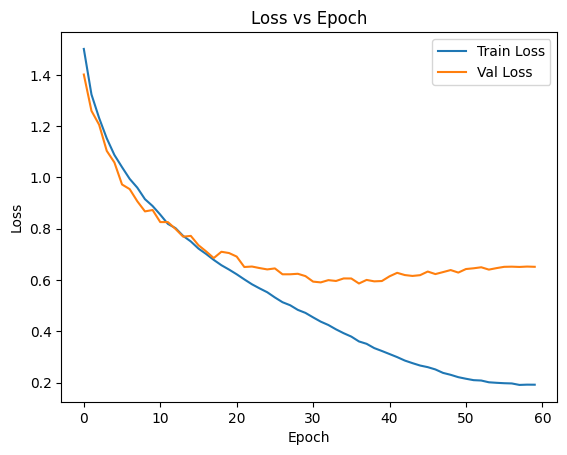

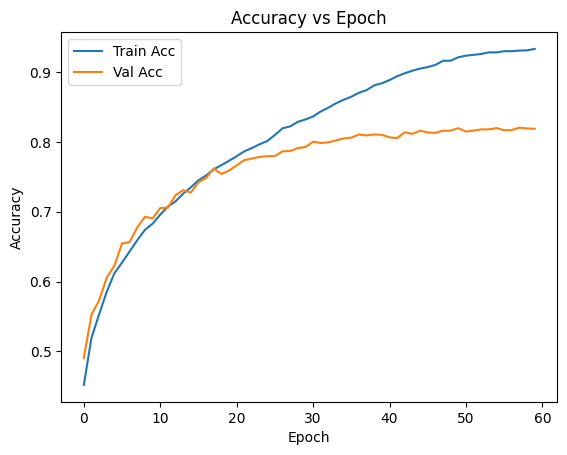

In [32]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

---------------------------------------------------------------------------------------------------

#### Final eval & confusion matrix

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [34]:
val_loss, val_acc, val_prec, val_rec, val_f1, cm = evaluate(vit, test_loader, device)
print(f"Final Test Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

Final Test Loss: 0.6514, Acc: 0.8189, Prec: 0.8192, Rec: 0.8189, F1: 0.8185


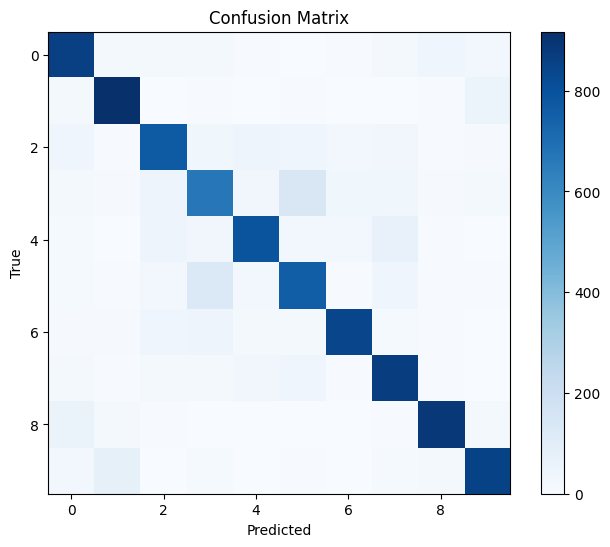

In [35]:
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar(); plt.show()

---------------------------------------------------------------------------------------------------

#### Saving model

In [60]:
torch.save(vit.state_dict(), "vit_cifar10.pth")
print("Model saved -> vit_cifar10.pth")

Model saved -> vit_cifar10.pth


In [36]:
torch.save(vit.state_dict(), "vit_cifar10_cosine.pth")
print("Model saved -> vit_cifar10_cosine.pth")

Model saved -> vit_cifar10_cosine.pth


---------------------------------------------------------------------------------------------------

#### Inference on a few test images

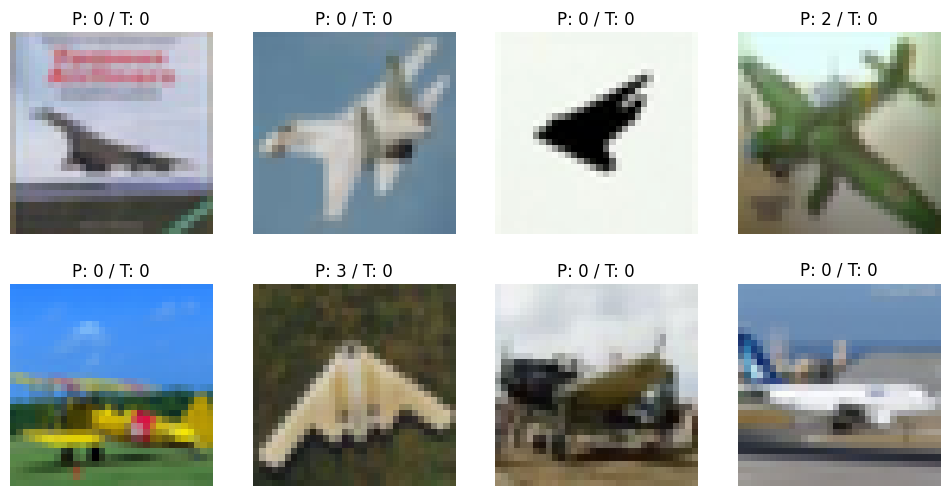

In [37]:
vit.eval()
imgs, labels = next(iter(test_loader))
imgs, labels = imgs[:8].to(device), labels[:8]
with torch.no_grad():
    preds = vit(imgs).argmax(dim=1).cpu()

fig, axes = plt.subplots(2,4, figsize=(12,6))
for img, pred, label, ax in zip(imgs.cpu(), preds, labels, axes.flatten()):
    img = img * torch.tensor(data_std).view(3,1,1) + torch.tensor(data_mean).view(3,1,1)
    ax.imshow(img.permute(1,2,0).clamp(0,1))
    ax.set_title(f"P: {pred} / T: {label.item()}")
    ax.axis('off')
plt.show()

6 out of 8 predicitons were correct!

Vision transformer results:
- train accuracy: 93.34
- test accuracy: 81.89
- val accuracy: 81.89

---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------

### Hybrid CNN+MLP model

In [44]:
class HybridCNNMLP(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3,
                 cnn_feature_dim=64, mlp_hidden=256, n_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.cnn_feature_dim = cnn_feature_dim
        # CNN encoder for each patch
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, cnn_feature_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # (B, cnn_feature_dim, 1, 1)
        )
        # MLP classifier
        self.mlp = nn.Sequential(
            nn.Linear(self.n_patches * cnn_feature_dim, mlp_hidden),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(mlp_hidden, n_classes)
        )

    def forward(self, x):
        B = x.size(0)
        # split into patches
        patches = x.unfold(2, self.patch_size, self.patch_size) \
                   .unfold(3, self.patch_size, self.patch_size)
        # (B, C, n_h, n_w, p, p)
        patches = patches.permute(0,2,3,1,4,5).contiguous()
        # reshape to (B*n_patches, C, p, p)
        patches = patches.view(-1, x.size(1), self.patch_size, self.patch_size)
        # encode each patch
        cnn_out = self.cnn(patches)        # (B*n_patches, cnn_feature_dim, 1,1)
        cnn_out = cnn_out.view(-1, self.cnn_feature_dim)  # (B*n_patches, feat)
        # group back to (B, n_patches*feat)
        feats = cnn_out.view(B, self.n_patches * self.cnn_feature_dim)
        # classify
        out = self.mlp(feats)
        return out

In [40]:
len(train_dataset)

50000

In [41]:
len(test_dataset)

10000

In [45]:
hybrid = HybridCNNMLP().to(device)

In [48]:
hybrid

HybridCNNMLP(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=1)
  )
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [49]:
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.AdamW(hybrid.parameters(), lr=3e-4, weight_decay=0.02)
scheduler_h = optim.lr_scheduler.CosineAnnealingLR(optimizer_h, T_max=60, eta_min=1e-6)
early_stopping_h = {"patience":10, "best_score":0.0, "epochs_no_improve":0}

In [50]:
n_epochs_h = 60
best_wts_h = copy.deepcopy(hybrid.state_dict())
history_h = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

In [51]:
# same train_one_epoch and evaluate functions as ViT
for epoch in range(1, n_epochs_h+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(hybrid, train_loader, criterion_h, optimizer_h, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, cm_h = evaluate(hybrid, test_loader, device)
    scheduler_h.step()

    history_h["train_loss"].append(tr_loss)
    history_h["train_acc"].append(tr_acc)
    history_h["val_loss"].append(val_loss)
    history_h["val_acc"].append(val_acc)
    history_h["val_f1"].append(val_f1)

    # Early stopping
    if val_acc > early_stopping_h["best_score"]:
        early_stopping_h["best_score"] = val_acc
        early_stopping_h["epochs_no_improve"] = 0
        best_wts_h = copy.deepcopy(hybrid.state_dict())
    else:
        early_stopping_h["epochs_no_improve"] += 1
        if early_stopping_h["epochs_no_improve"] >= early_stopping_h["patience"]:
            print(f"Hybrid early stopping @ epoch {epoch}")
            break

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | "
          f"Time: {time.time()-t0:.1f}s")

Epoch 01 | Train Loss: 1.8042 | Train Acc: 0.3488 | Val Loss: 1.5557 | Val Acc: 0.4508 | Val F1: 0.4299 | Time: 52.2s
Epoch 02 | Train Loss: 1.5467 | Train Acc: 0.4444 | Val Loss: 1.3738 | Val Acc: 0.5124 | Val F1: 0.5062 | Time: 50.6s
Epoch 03 | Train Loss: 1.4411 | Train Acc: 0.4824 | Val Loss: 1.3116 | Val Acc: 0.5319 | Val F1: 0.5214 | Time: 51.0s
Epoch 04 | Train Loss: 1.3764 | Train Acc: 0.5035 | Val Loss: 1.2577 | Val Acc: 0.5521 | Val F1: 0.5424 | Time: 50.9s
Epoch 05 | Train Loss: 1.3245 | Train Acc: 0.5230 | Val Loss: 1.2026 | Val Acc: 0.5764 | Val F1: 0.5725 | Time: 51.1s
Epoch 06 | Train Loss: 1.2850 | Train Acc: 0.5379 | Val Loss: 1.1586 | Val Acc: 0.5857 | Val F1: 0.5841 | Time: 50.8s
Epoch 07 | Train Loss: 1.2486 | Train Acc: 0.5539 | Val Loss: 1.1431 | Val Acc: 0.5965 | Val F1: 0.5967 | Time: 49.7s
Epoch 08 | Train Loss: 1.2165 | Train Acc: 0.5628 | Val Loss: 1.1073 | Val Acc: 0.6075 | Val F1: 0.6021 | Time: 51.5s
Epoch 09 | Train Loss: 1.1899 | Train Acc: 0.5733 | Val 

In [52]:
hybrid.load_state_dict(best_wts_h)

<All keys matched successfully>

In [53]:
# hybrid model
torch.save(hybrid.state_dict(), 'hybrid_cnn_mlp_cifar10.pth')
print("Saved Hybrid Model")

Saved Hybrid Model


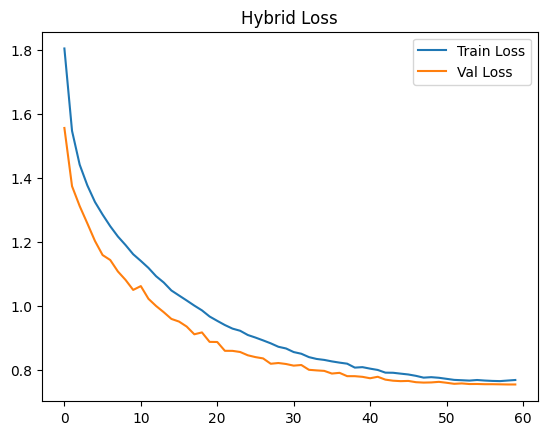

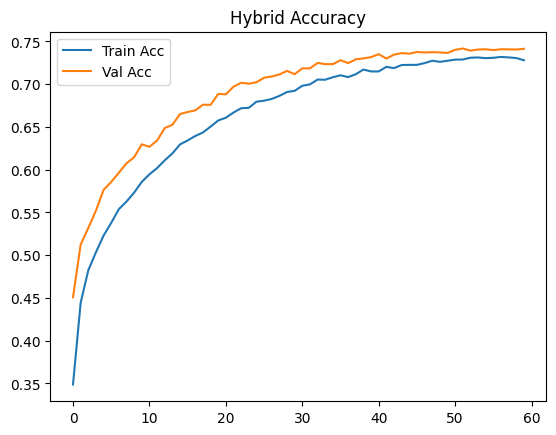

In [54]:
# hybrid training curves
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history_h["train_loss"], label="Train Loss")
plt.plot(history_h["val_loss"], label="Val Loss")
plt.title("Hybrid Loss")
plt.legend(); plt.show()

plt.figure()
plt.plot(history_h["train_acc"], label="Train Acc")
plt.plot(history_h["val_acc"], label="Val Acc")
plt.title("Hybrid Accuracy")
plt.legend(); plt.show()

In [55]:
# hybrid evaluation
print("Hybrid Final Eval:")
val_loss, val_acc, val_prec, val_rec, val_f1, cm_h = evaluate(hybrid, test_loader, device)
print(f"Loss {val_loss:.4f}, Acc {val_acc:.4f}, F1 {val_f1:.4f}")

Hybrid Final Eval:
Loss 0.7562, Acc 0.7418, F1 0.7399


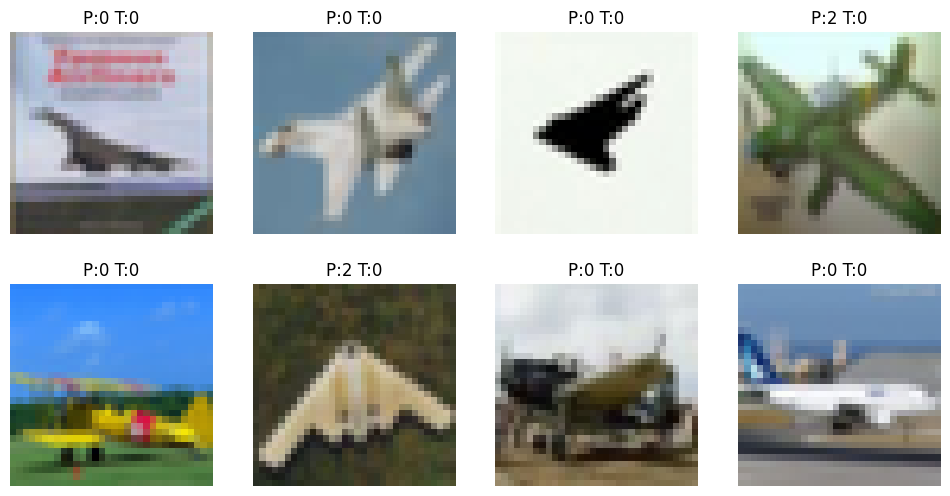

In [57]:
# Inference on sample images
hybrid.eval()
imgs, labels = next(iter(test_loader))
imgs, labels = imgs[:8].to(device), labels[:8]
with torch.no_grad(): preds = hybrid(imgs).argmax(dim=1).cpu()
fig, axes = plt.subplots(2,4, figsize=(12,6))
for img, p, t, ax in zip(imgs.cpu(), preds, labels, axes.flatten()):
    img = img * torch.tensor(data_std).view(3,1,1) + torch.tensor(data_mean).view(3,1,1)
    ax.imshow(img.permute(1,2,0).clamp(0,1))
    ax.set_title(f"P:{p.item()} T:{t.item()}")
    ax.axis('off')
plt.show()

6 out 8 predictions are correct

CNN-MLP results:
- train accuracy: 72.18
- test accuracy: 74.18
- val accuracy: 74.14

---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------

### Finetuning ResNet18

In [58]:
from torchvision import models

##### loading & editing ResNet

In [66]:
# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# modifying 1st conv for 32x32 input
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet.maxpool = nn.Identity()

# freeze all except final fc
for param in resnet.parameters():
    param.requires_grad = False
in_feats = resnet.fc.in_features
resnet.fc = nn.Linear(in_feats, 10)
resnet = resnet.to(device)

In [67]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [74]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Optimizer, scheduler, early stopping
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.fc.parameters(), lr=1e-3, weight_decay=0.02)
scheduler = CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)

---------------------------------------------------------------------------------------------------

In [82]:
def train_one_epoch(model, loader):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss  += loss.item() * x.size(0)
        running_corrects += (out.argmax(1)==y).sum().item()
    return running_loss/len(loader.dataset), running_corrects/len(loader.dataset)

In [83]:
def evaluate(model, loader):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    all_pred, all_true = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_loss += loss.item() * x.size(0)
            preds = out.argmax(1)
            running_corrects += (preds==y).sum().item()
            all_pred.append(preds.cpu().numpy())
            all_true.append(y.cpu().numpy())
    y_pred = __import__('numpy').concatenate(all_pred)
    y_true = __import__('numpy').concatenate(all_true)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return running_loss/len(loader.dataset), acc, prec, rec, f1, cm


##### Training loop

In [77]:
n_epochs = 60
best_wts = copy.deepcopy(resnet.state_dict())
best_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

In [84]:
for epoch in range(1, n_epochs+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(resnet, train_loader)
    val_loss, val_acc, val_prec, val_rec, val_f1, cm = evaluate(resnet, test_loader)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # checkpoint best
    if val_acc > best_acc:
        best_acc = val_acc
        best_wts = copy.deepcopy(resnet.state_dict())

    # <-- Corrected f-string below: use matching quotes, remove backslash -->
    print(f"Epoch {epoch:02d} | Tr L {tr_loss:.4f} A {tr_acc:.4f} | "
          f"Val L {val_loss:.4f} A {val_acc:.4f} F1 {val_f1:.4f} | "
          f"{time.time()-t0:.1f}s")

Epoch 01 | Tr L 1.7372 A 0.3826 | Val L 1.5591 A 0.4480 F1 0.4463 | 51.2s
Epoch 02 | Tr L 1.5730 A 0.4423 | Val L 1.5068 A 0.4622 F1 0.4599 | 50.1s
Epoch 03 | Tr L 1.5536 A 0.4507 | Val L 1.4949 A 0.4689 F1 0.4618 | 51.9s
Epoch 04 | Tr L 1.5356 A 0.4609 | Val L 1.4835 A 0.4691 F1 0.4677 | 50.9s
Epoch 05 | Tr L 1.5325 A 0.4619 | Val L 1.4714 A 0.4745 F1 0.4716 | 51.7s
Epoch 06 | Tr L 1.5262 A 0.4580 | Val L 1.4931 A 0.4667 F1 0.4593 | 52.2s
Epoch 07 | Tr L 1.5242 A 0.4630 | Val L 1.4823 A 0.4770 F1 0.4684 | 51.3s
Epoch 08 | Tr L 1.5164 A 0.4645 | Val L 1.4897 A 0.4780 F1 0.4674 | 51.6s
Epoch 09 | Tr L 1.5081 A 0.4702 | Val L 1.4910 A 0.4735 F1 0.4736 | 50.3s
Epoch 10 | Tr L 1.5065 A 0.4699 | Val L 1.4774 A 0.4741 F1 0.4711 | 50.3s
Epoch 11 | Tr L 1.5145 A 0.4664 | Val L 1.4641 A 0.4770 F1 0.4739 | 50.8s
Epoch 12 | Tr L 1.5119 A 0.4687 | Val L 1.4705 A 0.4729 F1 0.4686 | 50.0s
Epoch 13 | Tr L 1.5087 A 0.4688 | Val L 1.4691 A 0.4811 F1 0.4741 | 49.9s
Epoch 14 | Tr L 1.5033 A 0.4696 | Val 

In [86]:
# load best weights
resnet.load_state_dict(best_wts)

<All keys matched successfully>

##### accuracy & loss curves

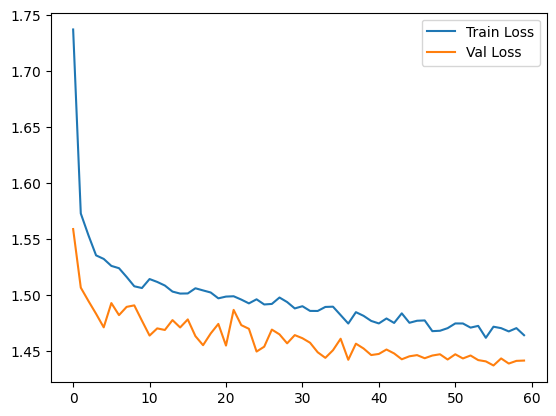

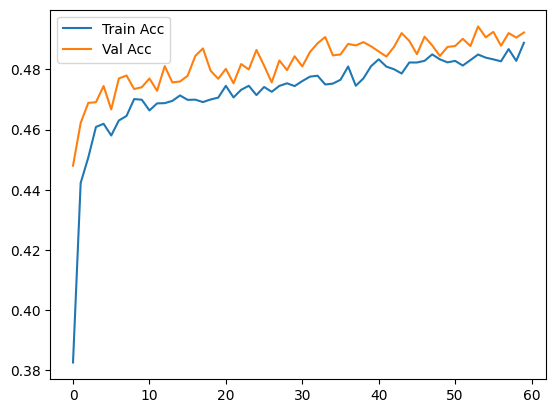

In [88]:
plt.figure(); plt.plot(history["train_loss"], label="Train Loss"); plt.plot(history["val_loss"], label="Val Loss"); plt.legend(); plt.show()
plt.figure(); plt.plot(history["train_acc"], label="Train Acc"); plt.plot(history["val_acc"], label="Val Acc"); plt.legend(); plt.show()

##### Final eval

ResNet Test Loss: 1.4422, Acc: 0.4943, Prec: 0.4921, Rec: 0.4943, F1: 0.4904


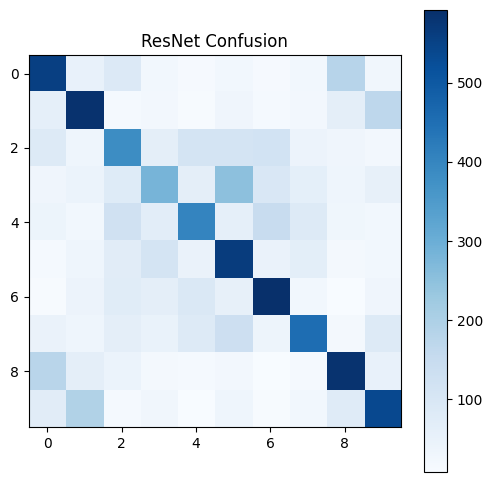

In [90]:
val_l, val_a, val_p, val_re, val_f1, cm_r = evaluate(resnet, test_loader)
print(f"ResNet Test Loss: {val_l:.4f}, Acc: {val_a:.4f}, Prec: {val_p:.4f}, Rec: {val_re:.4f}, F1: {val_f1:.4f}")
plt.figure(figsize=(6,6)); plt.imshow(cm_r, interpolation='nearest', cmap=plt.cm.Blues); plt.title("ResNet Confusion"); plt.colorbar(); plt.show()

##### Saving model

In [91]:
torch.save(resnet.state_dict(), "resnet18_cifar10.pth")
print("Saved -> resnet18_cifar10.pth")

Saved -> resnet18_cifar10.pth


##### Inference on 8 examples

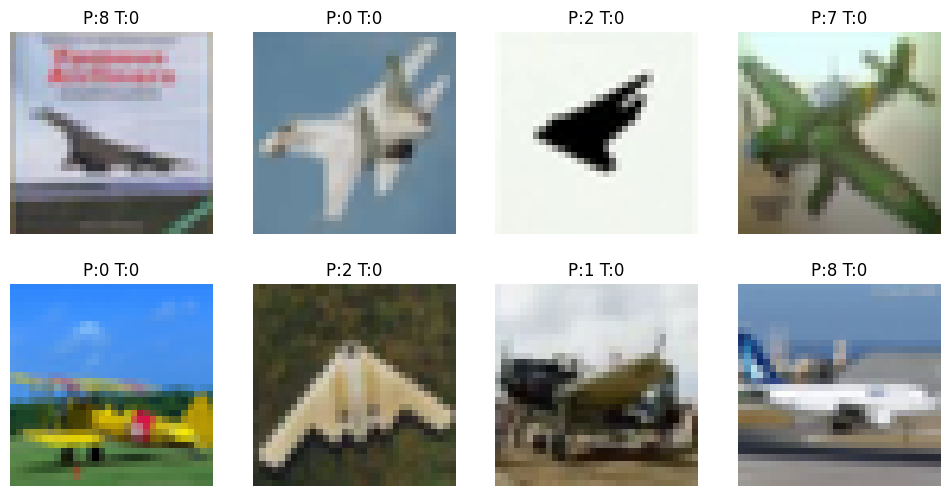

In [92]:
# Inference samples
resnet.eval()
imgs, labels = next(iter(test_loader))
imgs, labels = imgs[:8].to(device), labels[:8]
with torch.no_grad(): preds_r = resnet(imgs).argmax(dim=1).cpu()
fig, axes = plt.subplots(2,4,figsize=(12,6))
for img, p, t, ax in zip(imgs.cpu(), preds_r, labels, axes.flatten()):
    img = img * torch.tensor(data_std).view(3,1,1) + torch.tensor(data_mean).view(3,1,1)
    ax.imshow(img.permute(1,2,0).clamp(0,1)); ax.set_title(f"P:{p} T:{t}"); ax.axis('off')
plt.show()

only 2 out of 8 predictions are correct, worse than random guess?

CNN-MLP results:
- train accuracy: 48.89
- test accuracy: 49.23
- val accuracy: 49.43

---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------

### Comparison of the 3 models

In [93]:
models = ['Vision Transformer', 'Hybrid CNN-MLP', 'ResNet']
train_acc = [93.34, 72.18, 48.89]
test_acc  = [81.89, 74.18, 49.23]
val_acc   = [81.89, 74.14, 49.43]

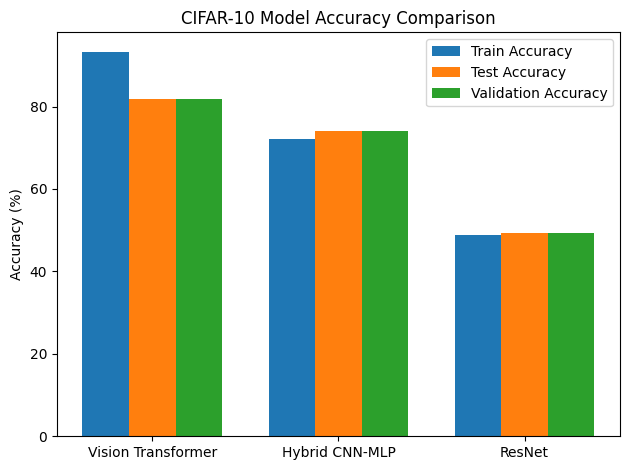

In [94]:
# Bar chart
x = np.arange(len(models))
width = 0.25

plt.figure()
plt.bar(x - width, train_acc, width, label='Train Accuracy')
plt.bar(x,        test_acc,  width, label='Test Accuracy')
plt.bar(x + width, val_acc,   width, label='Validation Accuracy')
plt.xticks(x, models)
plt.ylabel('Accuracy (%)')
plt.title('CIFAR-10 Model Accuracy Comparison')
plt.legend()
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------